In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
full_doc_path  = '/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/all.filt.txt'

In [ ]:
def letandspace(variable):
  return str.isalpha(variable) or variable == ' ' or str.isnumeric(variable)

def filtertxt(newsgroup):
  read_doc_path = f'/content/drive/Shareddrives/CSC591FinalProj/EncodedTextFiles/{newsgroup}.txt'
  write_doc_path = f'/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/{newsgroup}.filt.txt'

  ## Read document and convert to lowercase
  read_doc = open(read_doc_path, "r")
  data = read_doc.read().lower()
  read_doc.close()

  ## Create a list and remove header
  list_doc = data.split('\n')
  list_doc = [x for x in list_doc if not x.startswith('newsgroup:')]
  list_doc = [x for x in list_doc if not x.startswith('from:')]
  list_doc = [x for x in list_doc if not x.startswith('subject:')]
  list_doc = [x for x in list_doc if not x.startswith('in article')]
  rem_head = ' '.join(list_doc)

  ## Filter out data to alphanumeric and replace numbers with zeros
  filt_data = rem_head
  num_rem = ['1','2','3','4','5','6','7','8','9']
  filt_data = ''.join(filter(letandspace, filt_data))
  for char in num_rem:
    filt_data = filt_data.replace(char, '0')

  ## Remove document id number
  id_len = 7
  id_zer = '0'*id_len
  for i in range(id_len):
    filt_data = filt_data.replace(f'documentid {id_zer}','\n')
    id_zer = id_zer[:-1]
  with open(write_doc_path, "w") as text_file:
    text_file.write(filt_data)
  return filt_data

def create_vocab(txt_file_path):
  full_doc = open(txt_file_path, 'r')
  vector_words = CountVectorizer()
  full_vec = vector_words.fit_transform(full_doc)
  full_doc.close
  return vector_words

def vectorize_txt(txt_file_path, full_vocab):
  cur_doc = open(txt_file_path, "r")
  cur_vec = full_vocab.transform(cur_doc)
  cur_doc.close()
  return cur_vec.toarray().astype('uint8')[1:,:]

In [ ]:
newsgroup_list = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware',
                  'comp.sys.mac.hardware','comp.windows.x','misc.forsale','rec.autos','rec.motorcycles',
                  'rec.sport.baseball','rec.sport.hockey','sci.crypt','sci.electronics','sci.med',
                  'sci.space','soc.religion.christian','talk.politics.guns','talk.politics.mideast',
                  'talk.politics.misc','talk.religion.misc']
# newsgroup_list = ['sci.crypt','sci.space']

In [ ]:
## Filter Text
filt_start_time = time.time()
full_data = ''
for i in range(len(newsgroup_list)):
  cur_data = filtertxt(newsgroup_list[i])
  full_data = full_data + '\n' + cur_data
with open(full_doc_path, "w") as text_file:
  text_file.write(full_data)

filt_time = time.time()-filt_start_time
print(f"{math.floor(filt_time/60)} minutes, {filt_time % 60} seconds")

0 minutes, 37.562246322631836 seconds


In [ ]:
vect_start_time = time.time()
full_vocab = create_vocab(full_doc_path)
for i in range(len(newsgroup_list)):
  print(f'Vectorizing {newsgroup_list[i]}')
  cur_path = f'/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/{newsgroup_list[i]}.filt.txt'
  cur_vec = vectorize_txt(cur_path,full_vocab)
  cur_lab = np.ones(cur_vec.shape[0])*i
  cur_len = len(cur_lab)
  half_len = int(cur_len/2)
  cur_vec = cur_vec[:half_len,:]
  cur_lab = cur_lab[:half_len]
  if i == 0:
    full_vec = cur_vec
    full_lab = cur_lab
  else:
    full_vec = np.concatenate((full_vec,cur_vec),axis = 0)
    full_lab = np.concatenate((full_lab,cur_lab))

  # np.savetxt(f'/content/drive/Shareddrives/CSC591FinalProj/BinaryMatrices/{newsgroup_list[i]}.csv', cur_vec, delimiter=",")

vect_time = time.time()-vect_start_time
print(f"{math.floor(vect_time/60)} minutes, {vect_time % 60} seconds")

Vectorizing alt.atheism
Vectorizing comp.graphics
Vectorizing comp.os.ms-windows.misc
Vectorizing comp.sys.ibm.pc.hardware
Vectorizing comp.sys.mac.hardware
Vectorizing comp.windows.x
Vectorizing misc.forsale
Vectorizing rec.autos
Vectorizing rec.motorcycles
Vectorizing rec.sport.baseball
Vectorizing rec.sport.hockey
Vectorizing sci.crypt
Vectorizing sci.electronics
Vectorizing sci.med
Vectorizing sci.space
Vectorizing soc.religion.christian
Vectorizing talk.politics.guns
Vectorizing talk.politics.mideast
Vectorizing talk.politics.misc
Vectorizing talk.religion.misc
0 minutes, 38.49541163444519 seconds


In [ ]:
# Count every word
counts = np.sum(full_vec,axis = 0)

In [ ]:
# Remove uncommon words
freq_thr = 50
cnt_thr = counts > freq_thr
print(sum(cnt_thr))
trm_vec = full_vec[:,cnt_thr]

wpd = np.sum(trm_vec,axis = 1)   #words per doc
trm_vec = trm_vec[wpd>0,:]
short_wpd = wpd[wpd>0]
norm_len = 100
trm_vec = trm_vec/short_wpd[:,None]*100
trm_lab = full_lab[wpd>0]

6589


In [ ]:
np.sum(trm_vec, axis = 1)

array([100., 100., 100., ..., 100., 100., 100.])

In [ ]:
# Split data into training and test
lab_per_class = 100 # labeled train data per class
unlab_per_class = 500 # unlabeled train data per class
train_per_class = lab_per_class + unlab_per_class # train data per class
test_per_class = 50
total_lab = lab_per_class*20
total_unlab = unlab_per_class*20
total_test = test_per_class*20
for i in range(20):
  temp_data = trm_vec[trm_lab == i,:]
  arts = temp_data.shape[0]
  temp_ord = np.random.permutation(arts)
  temp_data = temp_data[temp_ord,:]
  temp_ltrain_data = temp_data[:lab_per_class,:]
  temp_unltrain_data = temp_data[lab_per_class:train_per_class,:]
  temp_test_data = temp_data[-test_per_class:,:]
  temp_ltrain_lab = np.ones(lab_per_class)*i
  temp_unltrain_lab = np.ones(unlab_per_class)*i
  temp_test_lab = np.ones(test_per_class)*i
  if i == 0:
    ltrain_lab = temp_ltrain_lab
    unltrain_lab = temp_unltrain_lab
    test_lab = temp_test_lab
    ltrain_data = temp_ltrain_data
    unltrain_data = temp_unltrain_data
    test_data = temp_test_data
  else:
    ltrain_lab = np.concatenate((ltrain_lab,temp_ltrain_lab))
    unltrain_lab = np.concatenate((unltrain_lab,temp_unltrain_lab))
    test_lab = np.concatenate((test_lab,temp_test_lab))
    ltrain_data = np.concatenate((ltrain_data,temp_ltrain_data))
    unltrain_data = np.concatenate((unltrain_data,temp_unltrain_data))
    test_data = np.concatenate((test_data,temp_test_data))
print(ltrain_data.shape)
print(unltrain_data.shape)
print(test_data.shape)

(2000, 6589)
(10000, 6589)
(1000, 6589)


In [ ]:
def init_p_lab_mult(data,lab,k_per_class):
  p_lab = np.zeros((len(lab),20*k_per_class))
  for i in range(len(lab)):
    rand_vals = np.random.uniform(0,1,k_per_class)
    rand_vals = rand_vals/sum(rand_vals)
    p_lab[i,int(lab[i])*k_per_class:int(lab[i]+1)*k_per_class] = rand_vals
  return p_lab

def compute_p_w_c_mult(data,p_lab,k_per_class):
  voc_len = data.shape[1]
  p_w_c = np.zeros((20*k_per_class,voc_len))
  for i in range(p_w_c.shape[0]):
    for j in range(voc_len):
      p_w_c[i,j] = np.dot(p_lab[:,i],data[:,j])
  p_w_c_sum = np.sum(p_w_c, axis = 1)
  p_w_c = (1+p_w_c)/(voc_len+p_w_c_sum[:,None])
  return p_w_c

def compute_p_c_mult(p_lab,k_per_class):
  p_c = (1+np.sum(p_lab,axis = 0))/(p_lab.shape[0]+p_lab.shape[1])
  return p_c

In [ ]:
k_per_class = 5
p_lab_mult = init_p_lab_mult(ltrain_data,ltrain_lab,k_per_class)
p_w_c_mult = compute_p_w_c_mult(ltrain_data,p_lab_mult,k_per_class)
p_c_mult = compute_p_c_mult(p_lab_mult,k_per_class)
print(p_lab_mult)
print(p_w_c_mult)
print(p_c_mult)

[[0.24236834 0.26397354 0.22183464 ... 0.         0.         0.        ]
 [0.29433871 0.25049261 0.09013782 ... 0.         0.         0.        ]
 [0.04962425 0.4589229  0.19344182 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.27000139 0.21469167 0.1590906 ]
 [0.         0.         0.         ... 0.203655   0.18705172 0.14311691]
 [0.         0.         0.         ... 0.26568942 0.26426408 0.10475572]]
[[0.00060137 0.00021131 0.00033953 ... 0.00011686 0.00011686 0.00011686]
 [0.00054599 0.00022065 0.00033991 ... 0.0001161  0.0001161  0.0001161 ]
 [0.00078705 0.00030206 0.00041876 ... 0.00011713 0.00011713 0.00011713]
 ...
 [0.00095183 0.00084782 0.00053859 ... 0.00011392 0.00011392 0.00011392]
 [0.00138415 0.0006322  0.00048317 ... 0.00011617 0.00011617 0.00011617]
 [0.00098949 0.000724   0.00052842 ... 0.00011943 0.00011943 0.00011943]]
[0.00984941 0.01011493 0.0097548  0.01024085 0.01004001 0.00931329
 0.01084758 0.0094688  0.01004796 0.01032236 

In [ ]:
## define prediction using classifier
def nb_classify(data,p_w_c,p_c):
  pred_lab = np.ones((data.shape[0],p_c.shape[0]))
  for i in range(pred_lab.shape[0]):
    cur_doc = data[i,:]
    for k in range(pred_lab.shape[1]):
      pred_lab[i,k] = np.product(np.power(10*p_w_c[k,:],cur_doc))
    pred_lab[i,:] = pred_lab[i,:]*p_c
    if sum(pred_lab[i,:])>0:
      pred_lab[i,:] = pred_lab[i,:]/sum(pred_lab[i,:])
  return pred_lab

In [ ]:
## Make predictions
pred_start = time.time()
pred_ltrain = nb_classify(ltrain_data,p_w_c_mult,p_c_mult)
pred_unltrain = nb_classify(unltrain_data,p_w_c_mult,p_c_mult)
pred_test = nb_classify(test_data,p_w_c_mult,p_c_mult)
print(f'{round(time.time()-pred_start)} seconds have passed')

99 seconds have passed


In [ ]:
def combine_mix_comp(mix_preds,k_per_class):
  class_preds = np.ones((mix_preds.shape[0],20))
  for i in range(20):
    class_preds[:,i] = np.sum(mix_preds[:,i*k_per_class:(i+1)*k_per_class],axis = 1)
  return class_preds

In [ ]:
np.sum(pred_ltrain, axis = 1)

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
## Check accuracy of each data set
class_pred_ltrain = combine_mix_comp(pred_ltrain,k_per_class)
class_pred_unltrain = combine_mix_comp(pred_unltrain,k_per_class)
class_pred_test = combine_mix_comp(pred_test,k_per_class)
pred_ltrain_lab = np.argmax(class_pred_ltrain, axis = 1)
pred_unltrain_lab = np.argmax(class_pred_unltrain, axis = 1)
pred_test_lab = np.argmax(class_pred_test, axis = 1)
print(f'Intial NB Classifier Labeled Training Data Accuracy: {sum(pred_ltrain_lab == ltrain_lab)/total_lab}')
print(f'Intial NB Classifier Unlabeled Training Data Accuracy: {sum(pred_unltrain_lab == unltrain_lab)/total_unlab}')
print(f'Intial NB Classifier Test Data Accuracy: {sum(pred_test_lab == test_lab)/total_test}')

Intial NB Classifier Labeled Training Data Accuracy: 0.9535
Intial NB Classifier Unlabeled Training Data Accuracy: 0.6448
Intial NB Classifier Test Data Accuracy: 0.607


In [ ]:
def clamp_p_lab(pred_ltrain,lab,k_per_class):
  clamp_pred_ltrain = np.zeros(pred_ltrain.shape)
  for i in range(clamp_pred_ltrain.shape[0]):
    clamp_pred_ltrain[i,int(lab[i])*k_per_class:int(lab[i]+1)*k_per_class] = pred_ltrain[i,int(lab[i])*k_per_class:int(lab[i]+1)*k_per_class]
    clamp_pred_ltrain[i,int(lab[i])*k_per_class:int(lab[i]+1)*k_per_class] /= sum(clamp_pred_ltrain[i,int(lab[i])*k_per_class:int(lab[i]+1)*k_per_class])
  return(clamp_pred_ltrain)

In [ ]:
pred_unltrain_new = pred_unltrain

In [ ]:
## EM
em_start = time.time()
dif = 1
iter = 0
old_test_acc = sum(pred_test_lab == test_lab)/total_test
data_aug = np.concatenate((ltrain_data,unltrain_data))
while dif >= 0.001:
  iter += 1
  print(f'Iteration {iter}')
  # M Step
  p_lab_aug = np.concatenate((clamp_p_lab(pred_ltrain,ltrain_lab,k_per_class),pred_unltrain_new))
  p_w_c_new = compute_p_w_c_mult(data_aug,p_lab_aug,k_per_class)
  p_c_new = compute_p_c_mult(p_lab_aug,k_per_class)
  # E Step
  pred_ltrain_new = nb_classify(ltrain_data,p_w_c_new,p_c_new)
  pred_unltrain_new = nb_classify(unltrain_data,p_w_c_new,p_c_new)
  pred_test_new = nb_classify(test_data,p_w_c_new,p_c_new)

  class_pred_ltrain_new = combine_mix_comp(pred_ltrain_new,k_per_class)
  class_pred_unltrain_new = combine_mix_comp(pred_unltrain_new,k_per_class)
  class_pred_test_new = combine_mix_comp(pred_test_new,k_per_class)
  pred_ltrain_lab_new = np.argmax(class_pred_ltrain_new, axis = 1)
  pred_unltrain_lab_new = np.argmax(class_pred_unltrain_new, axis = 1)
  pred_test_lab_new = np.argmax(class_pred_test_new, axis = 1)
  print(f'Current NB Classifier Labeled Training Data Accuracy: {sum(pred_ltrain_lab_new == ltrain_lab)/total_lab}')
  print(f'Current NB Classifier Unlabeled Training Data Accuracy: {sum(pred_unltrain_lab_new == unltrain_lab)/total_unlab}')
  print(f'Current NB Classifier Test Data Accuracy: {sum(pred_test_lab_new == test_lab)/total_test}')
  print()

  new_test_acc = sum(pred_test_lab_new == test_lab)/total_test
  dif = abs(new_test_acc-old_test_acc)
  old_test_acc = new_test_acc
em_time = time.time()-em_start
print(f"EM Runtime: {math.floor(em_time/60)} minutes, {em_time % 60} seconds")

Iteration 1
Current NB Classifier Labeled Training Data Accuracy: 0.8425
Current NB Classifier Unlabeled Training Data Accuracy: 0.6587
Current NB Classifier Test Data Accuracy: 0.639

Iteration 2
Current NB Classifier Labeled Training Data Accuracy: 0.802
Current NB Classifier Unlabeled Training Data Accuracy: 0.6588
Current NB Classifier Test Data Accuracy: 0.638

Iteration 3
Current NB Classifier Labeled Training Data Accuracy: 0.78
Current NB Classifier Unlabeled Training Data Accuracy: 0.6595
Current NB Classifier Test Data Accuracy: 0.636

Iteration 4
Current NB Classifier Labeled Training Data Accuracy: 0.7695
Current NB Classifier Unlabeled Training Data Accuracy: 0.6591
Current NB Classifier Test Data Accuracy: 0.628

Iteration 5
Current NB Classifier Labeled Training Data Accuracy: 0.7675
Current NB Classifier Unlabeled Training Data Accuracy: 0.6587
Current NB Classifier Test Data Accuracy: 0.627

Iteration 6
Current NB Classifier Labeled Training Data Accuracy: 0.763
Curren

In [ ]:
clf = MultinomialNB(force_alpha=True)
clf.fit(ltrain_data,ltrain_lab)

MultinomialNB(force_alpha=True)

In [ ]:
NB_ltrain_pred = clf.predict(ltrain_data)
NB_unltrain_pred = clf.predict(unltrain_data)
NB_test_pred = clf.predict(test_data)
ltrain_cor = NB_ltrain_pred == ltrain_lab
unltrain_cor = NB_unltrain_pred == unltrain_lab
test_cor = NB_test_pred == test_lab
print(sum(ltrain_cor)/total_lab)
print(sum(unltrain_cor)/total_unlab)
print(sum(test_cor)/total_test)

0.995
0.341
0.35


# **EVERYTHING BELOW HERE UNUSED**




In [ ]:
## M Step
p_lab_aug = np.concatenate((p_lab,pred_unltrain_new))
data_aug = np.concatenate((ltrain_data,unltrain_data))
p_w_c_new = compute_p_w_c(data_aug,p_lab_aug,lam)
p_c_new = compute_p_c(p_lab_aug,lam)

KeyboardInterrupt: ignored

In [ ]:
## E Step
pred_start = time.time()
pred_ltrain_new = nb_classify(ltrain_data,p_w_c_new,p_c_new)
pred_unltrain_new = nb_classify(unltrain_data,p_w_c_new,p_c_new)
pred_test_new = nb_classify(test_data,p_w_c_new,p_c_new)
print(f'{round(time.time()-pred_start)} seconds have passed')

In [ ]:
pred_ltrain_lab_new = np.argmax(pred_ltrain_new, axis = 1)
pred_unltrain_lab_new = np.argmax(pred_unltrain_new, axis = 1)
pred_test_lab_new = np.argmax(pred_test_new, axis = 1)
print(f'Current NB Classifier Labeled Training Data Accuracy: {sum(pred_ltrain_lab_new == ltrain_lab)/total_lab}')
print(f'Current NB Classifier Unlabeled Training Data Accuracy: {sum(pred_unltrain_lab_new == unltrain_lab)/total_unlab}')
print(f'Current NB Classifier Test Data Accuracy: {sum(pred_test_lab_new == test_lab)/total_test}')

In [ ]:
## Calculate initial NB Classifier

# theta_wt|cj
voc_len = sum(cnt_thr)
p_w_c = np.zeros((20,voc_len))
p_lab = np.zeros((len(ltrain_lab),20))
for i in range(len(ltrain_lab)):
  p_lab[i,int(ltrain_lab[i])] = 1
for i in range(20):
  for j in range(voc_len):
    p_w_c[i,j] = np.dot(p_lab[:,i],ltrain_data[:,j])
p_w_c_sum = np.sum(p_w_c, axis = 1)
p_w_c = (1+p_w_c)/(voc_len+p_w_c_sum[:,None])

# theta_cj
p_c = (1+np.sum(p_lab,axis = 0))/(20+len(ltrain_lab))
print(p_lab)
print(p_w_c)
print(p_c)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[1.67689721e-03 8.75233577e-04 1.14761592e-03 ... 3.76081234e-05
  3.76081234e-05 3.76081234e-05]
 [8.20571503e-03 3.41465676e-03 2.99134752e-03 ... 3.76081234e-05
  3.80927017e-05 3.76081234e-05]
 [1.10889852e-02 3.76651372e-03 2.88249813e-03 ... 3.76081234e-05
  3.76081234e-05 3.76081234e-05]
 ...
 [2.55477597e-03 9.47908177e-04 3.79211733e-03 ... 3.76081234e-05
  3.76081234e-05 3.76081234e-05]
 [4.17102716e-03 1.63633629e-03 2.05703458e-03 ... 3.76081234e-05
  3.76081234e-05 3.76081234e-05]
 [1.47880410e-03 2.08789412e-03 1.22813855e-03 ... 3.76081234e-05
  3.76081234e-05 3.76081234e-05]]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]


In [ ]:
def nb_classify(data,p_w_c,p_c):
  pred_lab = np.ones((data.shape[0],20))
  for i in range(len(pred_lab)):
    cur_doc = data[i,:]
    for j in range(len(cur_doc)):
      for k in range(20):
        if cur_doc[j] != 0:
          pred_lab[i,k] = pred_lab[i,k]*p_w_c[k,j]**cur_doc[j]
    pred_lab[i,:] = pred_lab[i,:]*p_c
    if sum(pred_lab[i,:])>0:
      pred_lab[i,:] = pred_lab[i,:]/sum(pred_lab[i,:])
  return pred_lab

In [ ]:
wgts = np.concatenate((np.ones(4000),np.ones(16000)*0.4))
for i in range(10):
  ftrain_lab = np.concatenate((ltrain_lab,NB_unltrain_pred))
  ftrain_data = np.concatenate((ltrain_data,unltrain_data))
  clf2 = MultinomialNB(force_alpha = True)
  clf2.fit(ftrain_data,ftrain_lab,wgts)
  NB_unltrain_pred = clf2.predict(unltrain_data)

In [ ]:
sum(clf2.predict(unltrain_data) == unltrain_lab)/16000

0.7739375

In [ ]:
a = np.array(((1,9),(10,3)))
print(a)
b = np.delete(a,1,0)
print(b)

[[ 1  9]
 [10  3]]
[[1 9]]


In [ ]:
max(np.sum(trm_vec,axis = 1))

7190

In [ ]:
index_max = max(range(len(counts)), key=counts.__getitem__)
my_dict = full_vocab.vocabulary_
print("Most frequent word:", list(my_dict.keys())
      [list(my_dict.values()).index(index_max)])

Most frequent word: the


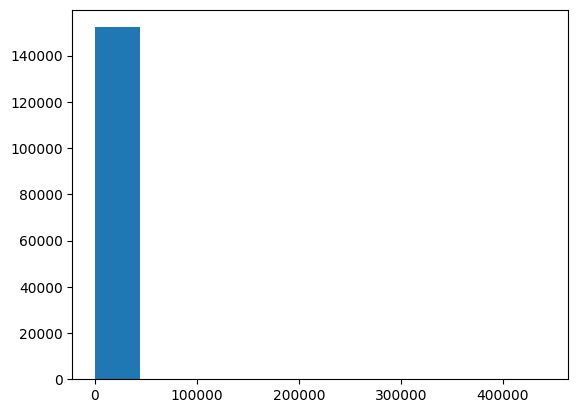

In [ ]:
counts = np.sum(full_vec,axis = 0)
plt.hist(counts)
plt.show()

In [ ]:
sortcounts = np.sort(counts)
sort_args = np.flip(np.argsort(counts))
print(np.flip(sort_args))

[   198  76122  84629 ... 102403 136716 135166]


In [ ]:
common_words = ''
for i in range(sum(cnt_thr)):
  common_words = common_words + '\n' + list(my_dict.keys())[list(my_dict.values()).index(sort_args[i])]


In [ ]:
print(common_words)

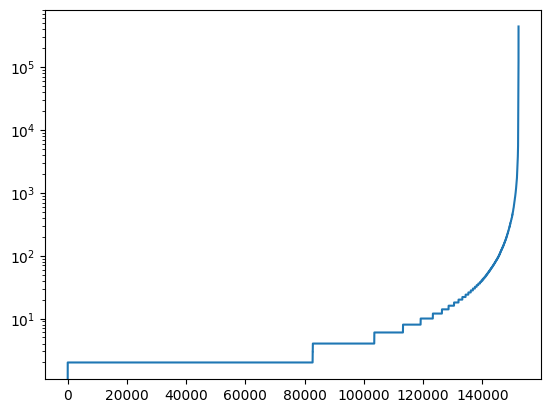

[     0      2      2 ... 209168 233981 441992]


In [ ]:
plt.plot(sortcounts)
plt.yscale('log')
plt.show()
print(sortcounts)

In [ ]:
vocab = create_vocab('/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/test.words.filt.txt')
cur_vec = vectorize_txt('/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/test.read.filt.txt',vocab)
np.ndarray.tofile(f'/content/drive/Shareddrives/CSC591FinalProj/BinaryMatrices/test.read.csv', cur_vec, delimiter=",")

print(vocab.vocabulary_)
# print(vectorize_txt('/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/test.read.filt.txt'))

{'with': 3, 'simple': 2, 'if': 0, 'see': 1}


TypeError: ignored

In [ ]:
full_doc = open(full_doc_path, 'r')
vector_words = CountVectorizer()
full_vec = vector_words.fit_transform(full_doc)
full_doc.close()
for i in range(len(newsgroup_list)):
  cur_doc = open(write_doc_path, "r")
  cur_vec = vector_words.transform(cur_doc)
  cur_doc.close()


In [ ]:
sum(sum(cur_vec))/(cur_vec.shape[0]*cur_vec.shape[1])

0.0006846888243485743

In [ ]:
#### GET RID OF NEWSGROUP TEXT AND MAYBE FROMS, CREATE VOCAB FROM ALL FILES ####
newsgroup = 'alt.atheism'
test_doc_path = f'/content/drive/Shareddrives/CSC591FinalProj/EncodedTextFiles/{newsgroup}.txt'
write_doc_path = f'/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/{newsgroup}.filt.txt'

test_doc = open(test_doc_path, "r")
data = test_doc.read().lower()

list_doc = data.split('\n')
list_doc = [x for x in list_doc if not x.startswith('newsgroup:')]
list_doc = [x for x in list_doc if not x.startswith('from:')]
list_doc = [x for x in list_doc if not x.startswith('subject:')]
list_doc = [x for x in list_doc if not x.startswith('in article')]
rem_head = ' '.join(list_doc)
print(list_doc)

# filt_data = rem_head
# char_rem = ['\n','newsgroup',newsgroup]
# for char in char_rem:
#   filt_data = filt_data.replace(char,' ')
filt_data = rem_head

num_rem = ['1','2','3','4','5','6','7','8','9']
filt_data = ''.join(filter(letandspace, filt_data))
for char in num_rem:
  filt_data = filt_data.replace(char, '0')


id_len = 7
id_zer = '0'*id_len
for i in range(id_len):
  filt_data = filt_data.replace(f'documentid {id_zer}','\n')
  id_zer = id_zer[:-1]
with open(write_doc_path, "w") as text_file:
  text_file.write(filt_data)

filt_test = open(write_doc_path, "r")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(filt_test)
test_doc.close()
filt_test.close()
vocab = vectorizer.vocabulary_
bow = np.array(X.toarray()>0).astype('uint8')[1:,:]
print(bow)
print(vocab)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]]
{'archivename': 908, 'atheismintroduction': 1085, 'altatheismarchivename': 616, 'introduction': 6737, 'lastmodified': 7309, 'april': 887, '0000': 2, 'version': 13771, '00': 0, 'begin': 1393, 'pgp': 9563, 'signed': 11796, 'message': 8058, 'an': 685, 'to': 13086, 'atheism': 1078, 'by': 1919, 'mathew': 7900, 'mathewmantiscouk': 7901, 'this': 12982, 'article': 973, 'attempts': 1126, 'provide': 10251, 'general': 5368, 'whilst': 14084, 'have': 5773, 'tried': 13277, 'be': 1352, 'as': 984, 'neutral': 8605, 'possible': 9832, 'regarding': 10741, 'contentious': 2844, 'issues': 6863, 'you': 14341, 'should': 11754, 'always': 645, 'remember': 10842, 'that': 12895, 'document': 3915, 'represents': 10922, 'only': 9022, 'one': 9008, 'viewpoint': 13801, 'would': 14256, 'encourage': 4291, 'read': 10571, 'widely': 14124, 'and': 708, 'draw': 3996, 'your': 14348, 'own': 9213, 'conclusions':

In [ ]:
import numpy
a = numpy.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
numpy.savetxt('/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/test_csv.csv', a, delimiter=",")

In [ ]:
print(filt_data+filt_data)


 i am going to start with a simple sentence and see whether i can create a vocabulary lookup from this file with tensorflow  
 this is a new line to see if everything still works
 i am going to start with a simple sentence and see whether i can create a vocabulary lookup from this file with tensorflow  
 this is a new line to see if everything still works


In [ ]:
filt_test1 = open('/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/test.words.filt.txt', 'r')
filt_test = open(write_doc_path, "r")
vector_words = CountVectorizer()
Y = vector_words.fit_transform(filt_test1)
Z = vector_words.transform(filt_test)
filt_test.close()
filt_test1.close()
# print(Y.toarray())
print(Z.toarray())

[[ 0  0  0  0]
 [ 0  0  0  0]
 [33  6  4 18]
 ...
 [ 1  0  0  1]
 [ 0  0  0  3]
 [ 0  0  0  0]]


In [ ]:

id_len = 4
id_zer = '0'*id_len
for i in range(id_len):
  print(f'documentid {id_zer}')
  id_zer = id_zer[:-1]

documentid 0000
documentid 000
documentid 00
documentid 0


In [ ]:
a = X.toarray()
b = np.array(a>0).astype('uint8')
# print(np.array(a>0).astype('uint8'))
print(sum(a[5,:]))
print(sum(b[5,:]))

227
144


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
import chardet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# removing punctuations, numbers, operators, etc
def tokenize_paragraph(data, current_group, separation):
  index = 0
  processed_data = {}
  instance = 0
  # while index < len(data):
  #   if data[index] == separation:
  #     instance += 1
  #     processed_data[separation + str(instance)] = []

  #   if not data[index].isdigit() and data[index] not in string.punctuation and data[index] != current_group:
  #     processed_data[separation + str(instance)].append()
  #     #del data[index]

  #   else:
  #     index += 1
  # return data

  for item in data:
    if item == separation:
      instance += 1
      processed_data[separation + str(instance)] = []

    if not data[index].isdigit() and data[index] not in string.punctuation and data[index] != current_group:
      processed_data[separation + str(instance)].append(item)

  return processed_data

Still need to work on the codec issue, but the program should be able to remove non-english characters.

In [ ]:
# opening the file in read mode
test_doc_path = '/content/drive/Shareddrives/CSC591FinalProj/EncodedTextFiles/rec.autos.txt'

with open(test_doc_path, 'rb') as file:
  result = chardet.detect(file.read())

test_doc = open(test_doc_path,"r", encoding = result['encoding'])

# reading the file
data = test_doc.read()
# print(data)

# prepare tokenized data
tokenized_data = word_tokenize(data)
print(tokenized_data)

# identify current newsgroup
current_group = 'rec.autos'
current_separation = 'Newsgroup'
latest_data = tokenize_paragraph(tokenized_data, current_group, current_separation)

with open('/content/drive/Shareddrives/CSC591FinalProj/EncodedTextFiles/rec.autos.out.txt', 'w') as new_file:
  for word in latest_data:
    new_file.write('%s\n'%latest_data[word])

print(latest_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
test = {}
header = 'what'
instance = 1
test[header + str(instance)] = 'testing value'
print('testing value' not in test[header+str(instance)])

False
